In [205]:
import glob,os

import numpy as np

import matplotlib.pyplot as plt

from PIL import Image 

Input your start number of photo: 1
Number of images: 400
Size of picture:(112, 92)
Sample: 0
Number of photo: 1


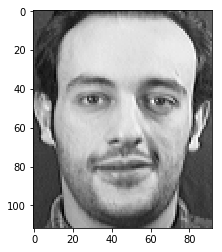

In [239]:
def preprocesing (path):
    #counting the number of pictures
    path = "faces/s*/*.pgm"
    start_photo = int(input('Input your start number of photo: '))
    index1 = start_photo - 1
    files = glob.glob(path)
    strings = len(files)
    print(f'Number of images: {strings}')

    #counting the size of picture
    fname = files[index]
    picture = np.array(Image.open(fname))
    columns = picture.shape[0]*picture.shape[1]
    height = picture.shape[0]
    width = picture.shape[1]
    picture_size = picture.shape
    print(f'Size of picture:{picture_size}')
    print(f'Sample: {index1}\nNumber of photo: {start_photo}')
    plt.imshow(picture, 'gray')
    return files,strings,columns,picture_size,height,width,index1

#picture test 
files, strings, columns, picture_size,height,width, index1 = preprocesing(path)
pic_size = picture_size

In [240]:
def create_matrix (files, strings, columns):
    string = 0
    labels = []
    data = np.zeros((strings, columns))
    for f in files:
        pctr = np.array(Image.open(f))
        pctr = pctr.reshape(1, pctr.shape[0] * pctr.shape[1])
   
        #create dataset
        data[string, :] = pctr
        string += 1 
   
        #create labels for pictures
        fname,ext = os.path.splitext(f)
        _,name,indx, = fname.split('/')
        labels.append(int(name[1:]))
    labels=np.array(labels).reshape(len(labels),1)
    return data, labels

#creating dataset from pictures
data, labels = create_matrix (files,strings,columns)
print('Dataset shape: ', data.shape)
print('Labels shape: ', labels.shape)
print('Pic size ',pic_size)

Dataset shape:  (400, 10304)
Labels shape:  (400, 1)
Pic size  (112, 92)


In [241]:
def vectorization(v, w = (height,width)):
    picture = v.reshape(w[0],w[1])
    return picture

def print_picture(ind, data, labels ,size = (height,width)):
    picture = vectorization(data[ind], size)
    plt.imshow(picture, 'gray')
    plt.title(f'label:{(np.squeeze(labels)[ind])}')

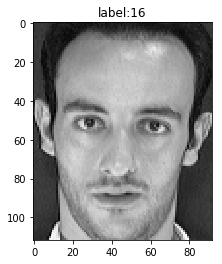

In [242]:
print_picture(index1, data, labels)

In [243]:
def choice_ind(ind1, ind2):
    
    #correct indet while 1st elem has 0 
    ind1 -=  1
    ind2 -=  1
    
    #select index
    ind1 = [i + 10 for i in range(ind1 - 10,390,10)]
    ind2 = [i + 10 for i in range(ind2 - 10,390,10)]
    test_index = np.concatenate((ind1, ind2))
   
    return test_index

In [244]:
def split(data, ind1 = 9 , ind2 = 10):
    
    #create index
    index = choice_ind(ind1, ind2)
    
    #create test dataset
    test_set = data[index,:]
    test_labels = labels[index]
    
    #create train dataset
    train_set = np.delete(data, index, axis = 0)
    train_labels = np.delete(labels, index)
    train_labels = train_labels.reshape(len(train_labels),1)
    
    return train_set, train_labels, test_set, test_labels


In [245]:
train_set, train_labels, test_set, test_labels = split(data)
print(f'Train set shape>> {train_set.shape} train labels shape>> {train_labels.shape}')
print(f'Test set shape>> {test_set.shape} test labels shape>> {test_labels.shape}')
train_origin=train_set
test_origin=test_set

Train set shape>> (320, 10304) train labels shape>> (320, 1)
Test set shape>> (80, 10304) test labels shape>> (80, 1)


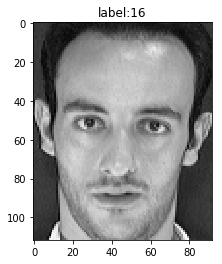

In [246]:
#test trains_dataset
print_picture(index1, train_set, train_labels)

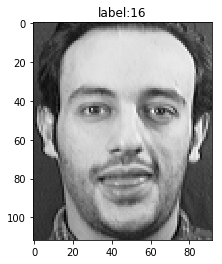

In [247]:
#test dataset of test samples
print_picture(index1, test_set, test_labels)

In [248]:
def identify_face(train_set, unknown_set):
    minimal_dist = []
    
    #create vector of indexes
    for ind in range (unknown_set.shape[0]):
        dist = np.linalg.norm(train_set - unknown_set[ind,:], axis = 1, keepdims = True)
        minimal_dist.append(np.argmin(dist))
    pred_index = np.array(minimal_dist).reshape(len(minimal_dist), 1)
    return pred_index
   
def accuracy(train_labels, test_labels, pred_index, index = 1):
    if index: 
        yhat = np.squeeze(train_labels[pred_index])
    else:
        yhat = pred_index
    ytest = np.squeeze(test_labels)
    compare = yhat == ytest
    err_index = np.where(compare == False)
    true_index = np.where(compare == True)
    true_ans = sum(compare)
    accur = (true_ans / test_labels.shape[0]) * 100
    return accur, err_index, true_index


In [278]:
def recognition(train_set, train_labels, test_set, test_labels, figsize = (10, 10), 
                index = 1, norm = 0, axis = 0, pca_flag = False, pca_nrg = 0.98, log = True, lbp_flag = False):
    
    if lbp_flag:
        train_set = create_lbp_set(train_set)
        test_set = create_lbp_set(test_set)
        
    #Normaliz
    if norm == 1:
        train_set = subtract_mean(train_set, axis = axis)
        test_set = subtract_mean(test_set, axis = axis)
    elif norm == 2:
        train_set = standart_norm(train_set, axis = axis)
        test_set = standart_norm(test_set, axis = axis)
      
    if pca_flag:
        if norm == 0:
            print('You need normalization!')
        train_set, transform_pca = pca(train_set, pca_nrg = pca_nrg, log = log)
        test_set = np.dot(transform_pca, test_set.T).T
        
    pred_index = identify_face(train_set, test_set)
    
    accur, err_index, true_index = accuracy(train_labels, test_labels, pred_index, index = index)
    if log:
        print(f'Accuracy  >> {accur}%', )
    
    return accur

In [280]:
#Simple recognition result
recognition(train_set, train_labels, test_set, test_labels)

Accuracy  >> 96.25%


96.25

# Normalization & Optimization

In [281]:
def subtract_mean(x, axis=0):
    return x - x.mean(axis = axis,keepdims = True)

def standart_norm(X, axis = 0):
    A = (X - X.mean(axis = axis, keepdims = True)) / X.std( axis = axis, keepdims = True)
    return A

In [282]:
print('Normalization by features(subtract mean)')
recognition(train_set, train_labels, test_set, test_labels,norm = 1, axis = 0)

Normalization by features(subtract mean)
Accuracy  >> 96.25%


96.25

In [283]:
print('Normalization by samples(subtract mean)')
recognition(train_set, train_labels, test_set, test_labels,norm = 1, axis = 1)

Normalization by samples(subtract mean)
Accuracy  >> 95.0%


95.0

In [284]:
print('Normalization by features(standart norm)')
recognition(train_set, train_labels, test_set, test_labels,norm = 2, axis = 0)

Normalization by features(standart norm)
Accuracy  >> 96.25%


96.25

In [285]:
print('Normalization by samples(standart norm)')
recognition(train_set, train_labels, test_set, test_labels,norm = 2, axis = 1)

Normalization by samples(standart norm)
Accuracy  >> 95.0%


95.0

#### *Accuracy didn't grow up after standart & subtract method of noemlization!*

# PCA method

In [293]:
def pca(X, pca_nrg = 0.98, log = False):
    #Create covariance matrix
    C = np.dot(X, X.T)
    
    #Find out eigenvalues and eigenvectors
    eig, eig_v = np.linalg.eig(C)
    
    #Choose type of pca model
    if (type(pca_nrg) == float or type(pca_nrg) == np.float64) and (pca_nrg < 1):
        n = X.shape[1]
        p = 1
        i = 0
        while p>pca_nrg:
            i += 1
            ind = np.argsort(-eig)[:n - i]
            p = np.sum(eig[ind]) / np.sum(eig)
        important_v = eig_v[ind]  
    elif pca_nrg == 1:
        important_v = eig_v 
    else:
        ind_big = np.argsort(-eig)[:int(pca_nrg)]
        important_v = eig_v[ind_big]
    W = np.dot(important_v,X)
    X_pca=np.dot(W,X.T)
    if log:
        print(f'pca_energy >> {pca_nrg}, the number of components >> {X_pca.T.shape[1]}')
        print(f'shape train dataset after projection into PCA subspace {X_pca.T.shape}')  
    return X_pca.T,W

In [297]:
print("Normalization by features(subtract_mean)")
for pca_nrg in [0.95, 0.96, 0.97, 0.98, 0.99]:
    acc = recognition(train_set,train_labels,test_set,test_labels, norm=1, axis=0, pca_flag=True, pca_nrg = pca_nrg)
    print(f'\n')

Normalization by features(subtract_mean)
pca_energy >> 0.95, the number of components >> 161
shape train dataset after projection into PCA subspace (320, 161)
Accuracy  >> 95.0%


pca_energy >> 0.96, the number of components >> 180
shape train dataset after projection into PCA subspace (320, 180)
Accuracy  >> 95.0%


pca_energy >> 0.97, the number of components >> 202
shape train dataset after projection into PCA subspace (320, 202)
Accuracy  >> 96.25%


pca_energy >> 0.98, the number of components >> 229
shape train dataset after projection into PCA subspace (320, 229)
Accuracy  >> 96.25%


pca_energy >> 0.99, the number of components >> 264
shape train dataset after projection into PCA subspace (320, 264)
Accuracy  >> 96.25%




In [298]:
print("Normalization by features(standart_norm)")
for pca_nrg in [0.95, 0.96, 0.97, 0.98, 0.99]:
    acc = recognition(train_set,train_labels,test_set,test_labels, norm=2, axis=0, pca_flag=True, pca_nrg = pca_nrg)
    print(f'\n')

Normalization by features(standart_norm)
pca_energy >> 0.95, the number of components >> 163
shape train dataset after projection into PCA subspace (320, 163)
Accuracy  >> 95.0%


pca_energy >> 0.96, the number of components >> 182
shape train dataset after projection into PCA subspace (320, 182)
Accuracy  >> 95.0%


pca_energy >> 0.97, the number of components >> 204
shape train dataset after projection into PCA subspace (320, 204)
Accuracy  >> 95.0%


pca_energy >> 0.98, the number of components >> 231
shape train dataset after projection into PCA subspace (320, 231)
Accuracy  >> 95.0%


pca_energy >> 0.99, the number of components >> 265
shape train dataset after projection into PCA subspace (320, 265)
Accuracy  >> 95.0%




In [299]:
print("Normalization by samples(subtract_mean)")
for pca_nrg in [0.95, 0.96, 0.97, 0.98, 0.99]:
    acc = recognition(train_set,train_labels,test_set,test_labels, norm=1, axis=1, pca_flag=True, pca_nrg = pca_nrg)
    print(f'\n')

Normalization by samples(subtract_mean)
pca_energy >> 0.95, the number of components >> 125
shape train dataset after projection into PCA subspace (320, 125)
Accuracy  >> 88.75%


pca_energy >> 0.96, the number of components >> 146
shape train dataset after projection into PCA subspace (320, 146)
Accuracy  >> 88.75%


pca_energy >> 0.97, the number of components >> 171
shape train dataset after projection into PCA subspace (320, 171)
Accuracy  >> 87.5%


pca_energy >> 0.98, the number of components >> 203
shape train dataset after projection into PCA subspace (320, 203)
Accuracy  >> 88.75%


pca_energy >> 0.99, the number of components >> 247
shape train dataset after projection into PCA subspace (320, 247)
Accuracy  >> 88.75%




In [300]:
print("Normalization by samples(standart_norm)")
for pca_nrg in [0.95, 0.96, 0.97, 0.98, 0.99]:
    acc = recognition(train_set,train_labels,test_set,test_labels, norm=2, axis=1, pca_flag=True, pca_nrg = pca_nrg)
    print(f'\n')

Normalization by samples(standart_norm)
pca_energy >> 0.95, the number of components >> 129
shape train dataset after projection into PCA subspace (320, 129)
Accuracy  >> 88.75%


pca_energy >> 0.96, the number of components >> 150
shape train dataset after projection into PCA subspace (320, 150)
Accuracy  >> 87.5%


pca_energy >> 0.97, the number of components >> 175
shape train dataset after projection into PCA subspace (320, 175)
Accuracy  >> 90.0%


pca_energy >> 0.98, the number of components >> 207
shape train dataset after projection into PCA subspace (320, 207)
Accuracy  >> 90.0%


pca_energy >> 0.99, the number of components >> 250
shape train dataset after projection into PCA subspace (320, 250)
Accuracy  >> 88.75%


